# Imports

In [352]:
# Data
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from interpret import show
import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Black Box Models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Glass Box Models
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score

# Metrics 
from sklearn.metrics import mean_squared_error

# XAI
from sklearn.inspection import permutation_importance
from interpret.blackbox import LimeTabular
import shap
import lime 
import lime.lime_tabular


# Other 
import pickle
from scipy import optimize

# Data

In [277]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [278]:
train_copy = train.copy()
test_copy = test.copy()

train_copy["set"] = np.repeat("train", train.shape[0])
test_copy["set"] = np.repeat("test", test.shape[0])

all = pd.concat([train_copy, test_copy])

In [279]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [280]:
train.shape

(1460, 81)

In [281]:
test.shape

(1459, 80)

Checking for missing data

In [282]:
(train.isnull().sum() / train.shape[0] * 100).sort_values(ascending=False)[:20]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

For most of these variables, missing value means that the feature is not avaiable. Might be some information in the few data points that don't have NA

In [283]:
missing_cols = train.columns[(train.isnull().sum() != 0)]

In [284]:
response = 'SalePrice'

cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype in ('int64', 'float64')]


predictors = cat_cols + num_cols
predictors.remove(response)

Check number of unique value for categorical variables

In [285]:
train[cat_cols].nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

## Missing data columns

In [286]:
missing_cols = train.columns[(train.isnull().sum() != 0)]

In [287]:
missing_cols 

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [288]:
missing_num_cols = [col for col in missing_cols if col in num_cols]
missing_cat_cols = [col for col in missing_cols if col in cat_cols]

In [289]:
missing_num_cols 

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

MasVnrArea is probably missing when there is no masonry veneer. Same assumption can be done for LotFrontage (Linear feet of street connected to property) and GarageYrBlt (year garage was built). 

### Check MasVnrArea assumption

In [290]:
(train["MasVnrArea"].isnull() == train["MasVnrType"].isnull()).all()

True

In [291]:
train["MasVnrArea"].fillna(value=0, inplace=True)

### Check GarageYrBlt assumption

In [292]:
(train["GarageYrBlt"].isnull() == train["GarageType"].isnull()).all()

True

In [293]:
train["GarageYrBlt"].fillna(value=0, inplace=True)

### Fill with zero for LotFrontage as well

This might be a wrong assumption

In [294]:
train["LotFrontage"].fillna(value=0, inplace=True)

Both assumptions are therefor sound. 

In [295]:
missing_cat_cols

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

## Defining ordinal categorical columns and one_hot columns

These columns have no natrual ordering and should therefor have one_hot encoding. 

In [296]:
one_hot_cols = ['Street', 'LotConfig', 'RoofStyle', 'Foundation', 'Heating', "Alley", 'Electrical', 'PoolQC', 'Fence', 'MiscFeature']

From the missing list above we see that Alley, Electrical, PoolQC, Fence and MiscFeature have missing values. Need to fill these with "missing", except for electrical, since no building can not have electricity.

In [297]:
train["Electrical"] = train["Electrical"].fillna(value= train['Electrical'].mode()[0])

In [298]:
train[one_hot_cols] = train[one_hot_cols].fillna(value = "Missing")

We need to check that each category has enough representation.

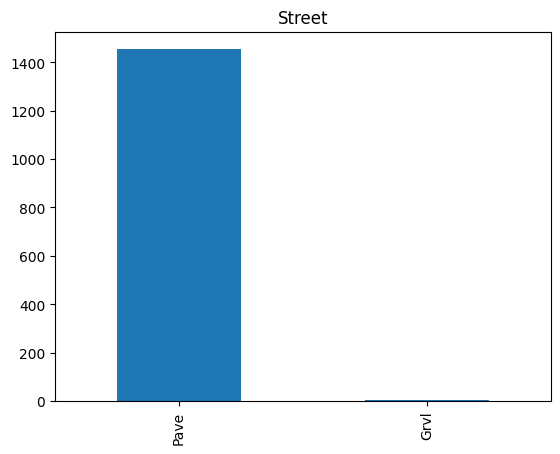

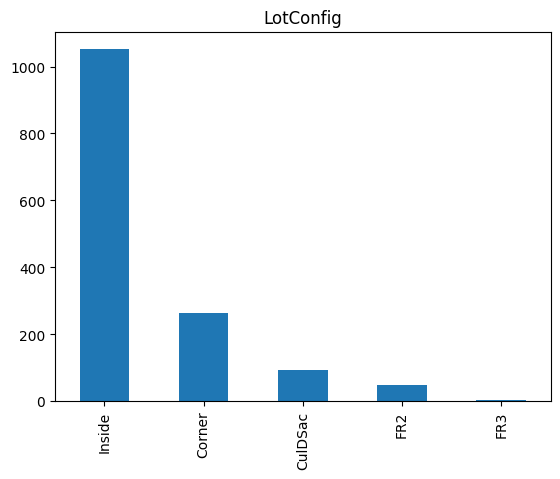

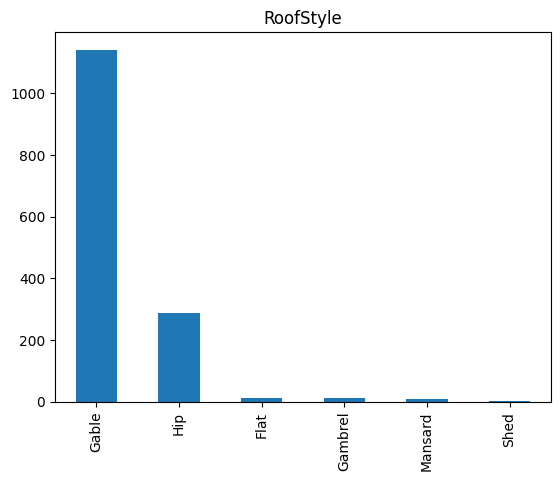

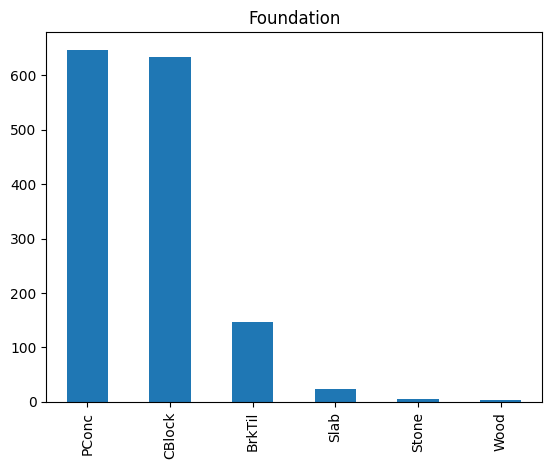

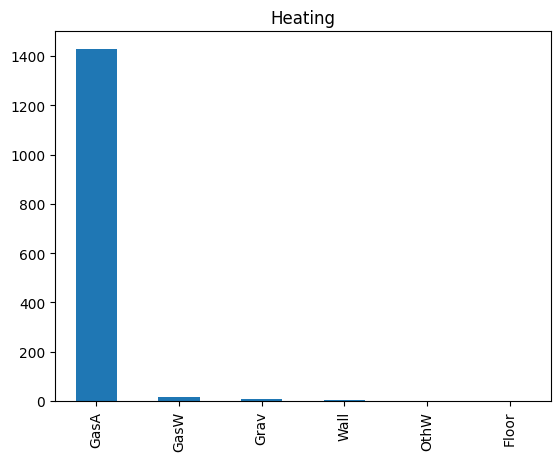

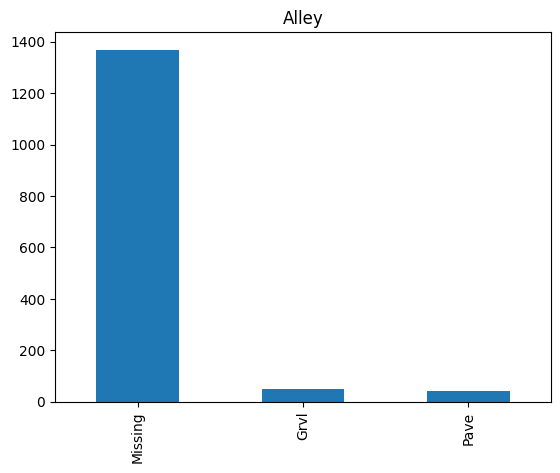

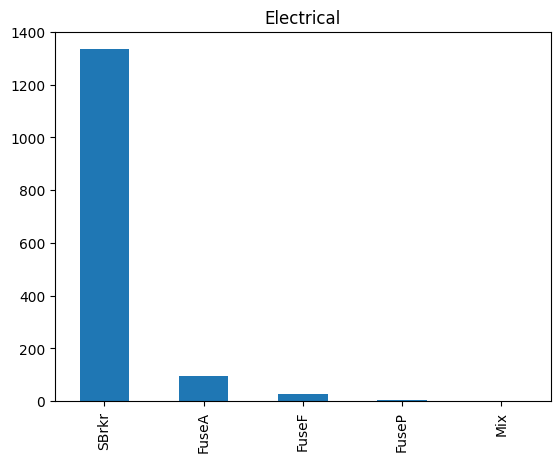

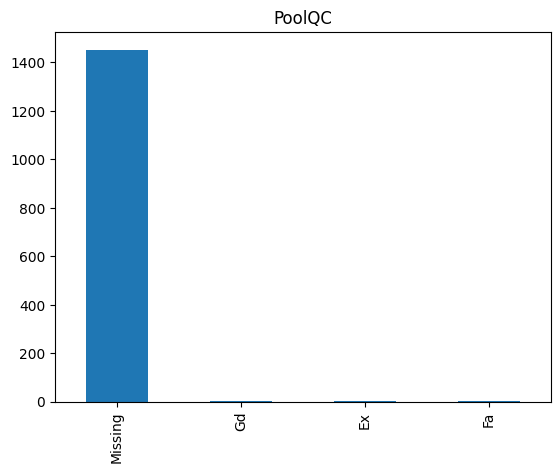

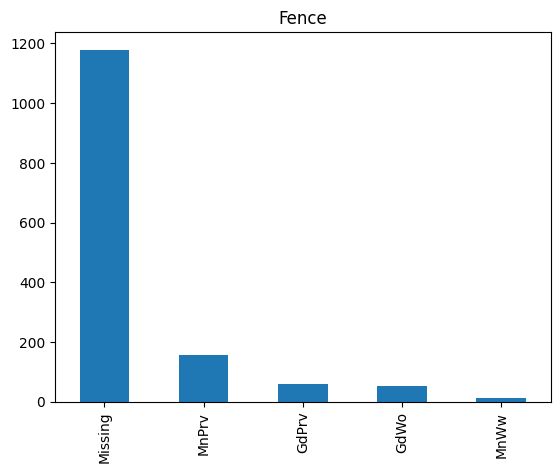

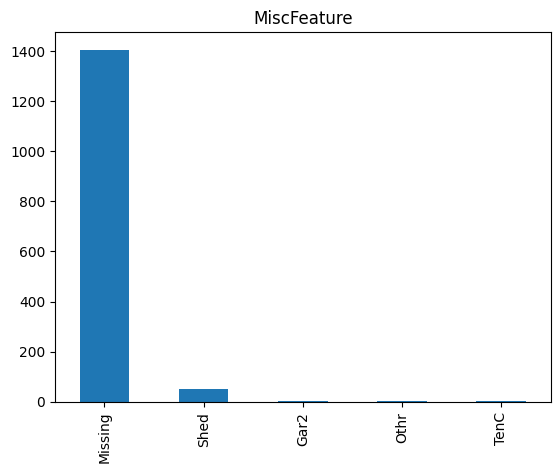

In [299]:
for var in one_hot_cols:
    plt.title(var)
    train[var].value_counts().plot(kind = "bar")
    plt.show()

Street is problematic since it does not have enough representation of it second category. We see that LotConfig have very few FR3 data points. Since FR3 is very similar to FR2 we are maybe justified to group these togheter. We might need to group some heating categories into one category, like grouping Wall, OthW and Floor into on category called other.

### Grouping of variables

#### LotConfig

In [300]:
train["LotConfig"].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [301]:
mapping = {"FR2" : "FR", "FR3" : "FR"}

train["LotConfig"] = train["LotConfig"].replace(mapping)

#### RoofStyle

In [302]:
train["RoofStyle"].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [303]:
mapping = {"Flat" : "Other", "Gambrel" : "Other", "Mansard" : "Other", "Shed" : "Other"}

train["RoofStyle"] = train["RoofStyle"].replace(mapping)

#### Foundation

In [304]:
train["Foundation"].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [305]:
mapping = {"Slab" : "Other", "Stone" : "Other", "Wood" : "Other"}

train["Foundation"] = train["Foundation"].replace(mapping)

#### Fence

In [306]:
train["Fence"].value_counts()

Missing    1179
MnPrv       157
GdPrv        59
GdWo         54
MnWw         11
Name: Fence, dtype: int64

In [307]:
mapping = {"GdWo" : "Other", "MnWw" : "Other"}

train["Fence"] = train["Fence"].replace(mapping)

#### MiscFeature

In [308]:
train["MiscFeature"].value_counts()

Missing    1406
Shed         49
Gar2          2
Othr          2
TenC          1
Name: MiscFeature, dtype: int64

In [309]:
mapping = {"Shed" : "Other", "Gar2" : "Other", "Othr" : "Other", "TenC" : "Other"}

train["MiscFeature"] = train["MiscFeature"].replace(mapping)

#### Heating

In [310]:
train["Heating"].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [311]:
mapping = {"GasW" : "Other", "Grav" : "Other", "Wall" : "Other", "OthW" : "Other", "Floor" : "Other"}

train["Heating"] = train["Heating"].replace(mapping)

#### Electrical

In [312]:
train["Electrical"].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [313]:
mapping = {"FuseF" : "Other", "FuseP" : "Other", "Mix" : "Other", "Missing" : "Other"}

train["Electrical"] = train["Electrical"].replace(mapping)

#### PoolQC

In [314]:
train["PoolQC"].value_counts()

Missing    1453
Gd            3
Ex            2
Fa            2
Name: PoolQC, dtype: int64

In [315]:
mapping = {"Missing" : "NoPool", "Gd" : "Pool", "Ex" : "Pool", "Fa" : "Pool"}

train["PoolQC"] = train["PoolQC"].replace(mapping)

We get only two categories, so we label encode pool instead and remove it from onehot_cols

In [316]:
mapping = {"NoPool" : 0, "Pool" : 1}

train["PoolQC"].replace(mapping, inplace = True)

one_hot_cols.remove("PoolQC")

## Ordinal categorical vaiables

These variables have a natrual ordering

In [317]:
ordinal_cols = ['LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive']

ordinal columns with missing values

In [318]:
ord_missing_cols = [col for col in ordinal_cols if col in missing_cols]
ord_missing_cols

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

All Bsmt variables have missing values when the house have no basement. FireplaceQu is missing when there is no fireplace. Garage variables have missing values when there is no garage. We might encode all missing with a zero to represent that not having a utility is the worst possible condition it can be in.

### Fill Missing

In [319]:
train[ord_missing_cols] = train[ord_missing_cols].fillna(value = "Missing")

Check wich categories are present

In [320]:
categories = pd.Series()
for i in range(len(ordinal_cols)):
    col = ordinal_cols[i]
    categories[col] = list(train[col].unique())

categories

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


LotShape                           [Reg, IR1, IR2, IR3]
LandContour                        [Lvl, Bnk, Low, HLS]
Utilities                              [AllPub, NoSeWa]
LandSlope                               [Gtl, Mod, Sev]
ExterQual                              [Gd, TA, Ex, Fa]
ExterCond                          [TA, Gd, Fa, Po, Ex]
BsmtQual                      [Gd, TA, Ex, Missing, Fa]
BsmtCond                      [TA, Gd, Missing, Fa, Po]
BsmtExposure                  [No, Gd, Mn, Av, Missing]
BsmtFinType1    [GLQ, ALQ, Unf, Rec, BLQ, Missing, LwQ]
HeatingQC                          [Ex, Gd, TA, Fa, Po]
KitchenQual                            [Gd, TA, Ex, Fa]
FireplaceQu               [Missing, TA, Gd, Fa, Ex, Po]
GarageFinish                   [RFn, Unf, Fin, Missing]
GarageQual                [TA, Fa, Gd, Missing, Ex, Po]
GarageCond                [TA, Fa, Missing, Gd, Po, Ex]
PavedDrive                                    [Y, N, P]
dtype: object

Some overlapping category names

In [321]:
mapping1 = {"Missing" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}

mapping2 = {"IR3" : 0, "IR2" : 1, "IR1": 2, "Reg" : 3}

mapping3 = {"Low" : 0, "HLS" : 1, "Bnk" : 2, "Lvl" : 3}

mapping4 = {"Sev" : 0, "Mod" : 1, "Gtl" : 2}

mapping5 = {"Missing" : 0, "No" : 1, "Mn" : 2, "Av" : 3, "Gd" : 4}

mapping6 = {"Missing" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}

mapping7 = {"Missing" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3}

mapping8 = {"N" : 0, "P" : 1, "Y" : 2}

mapping9 = {"AllPub" : 1, "NoSeWa" : 0}

In [322]:
train["ExterQual"].replace(mapping1, inplace=True)
train["ExterCond"].replace(mapping1, inplace=True)
train["BsmtQual"].replace(mapping1, inplace=True)
train["BsmtCond"].replace(mapping1, inplace=True)
train["HeatingQC"].replace(mapping1, inplace=True)
train["KitchenQual"].replace(mapping1, inplace=True)
train["FireplaceQu"].replace(mapping1, inplace=True)
train["GarageFinish"].replace(mapping1, inplace=True)
train["GarageQual"].replace(mapping1, inplace=True)
train["GarageCond"].replace(mapping1, inplace=True)

In [323]:
train["LotShape"].replace(mapping2, inplace=True)

train["LandContour"].replace(mapping3, inplace=True)

train["LandSlope"].replace(mapping4, inplace=True)

train["BsmtExposure"].replace(mapping5, inplace=True)

train["BsmtFinType1"].replace(mapping6, inplace=True)

train["GarageFinish"].replace(mapping7, inplace=True)

train["PavedDrive"].replace(mapping8, inplace=True)

train["Utilities"].replace(mapping9, inplace=True)

## Other categorical variables

Don't know what to do with these yet

In [324]:
used_cat_cols = ordinal_cols + one_hot_cols
unused_cat_cols = [col for col in cat_cols if col not in used_cat_cols]
unused_cat_cols

['MSZoning',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtFinType2',
 'CentralAir',
 'Functional',
 'GarageType',
 'PoolQC',
 'SaleType',
 'SaleCondition']

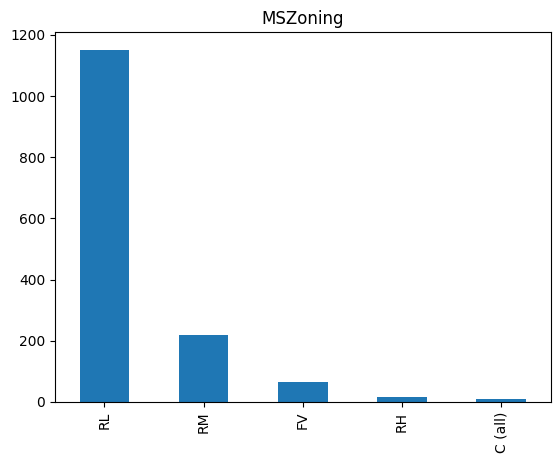

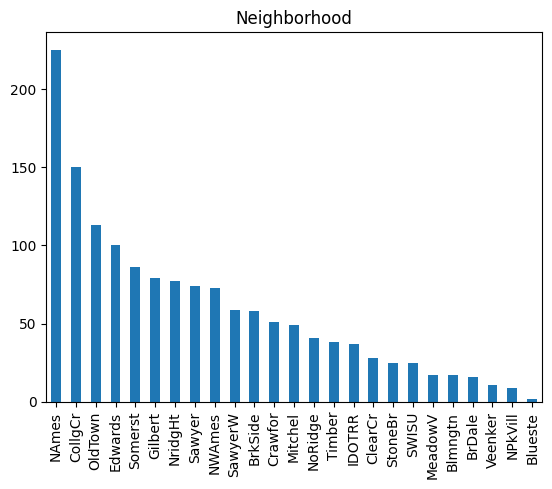

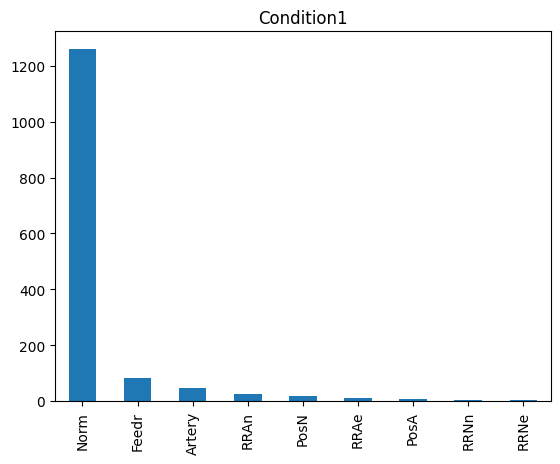

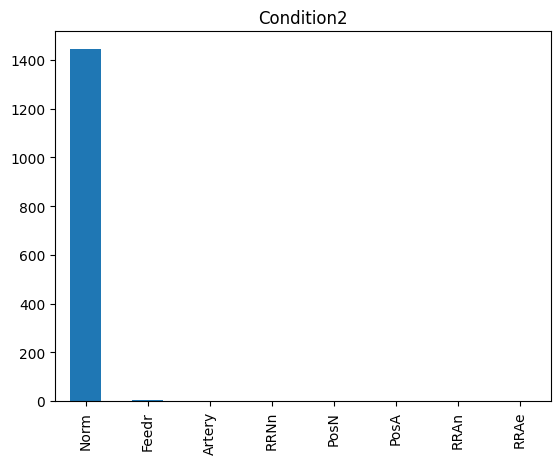

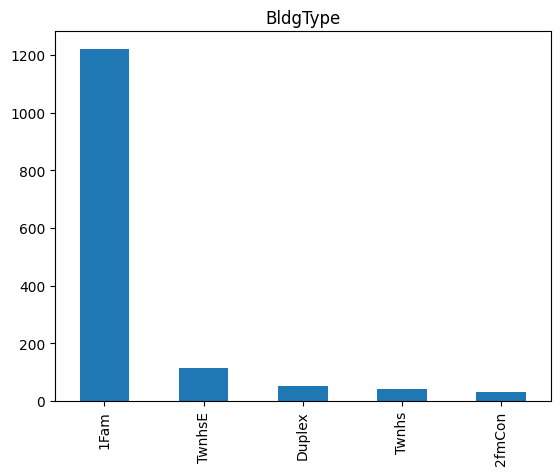

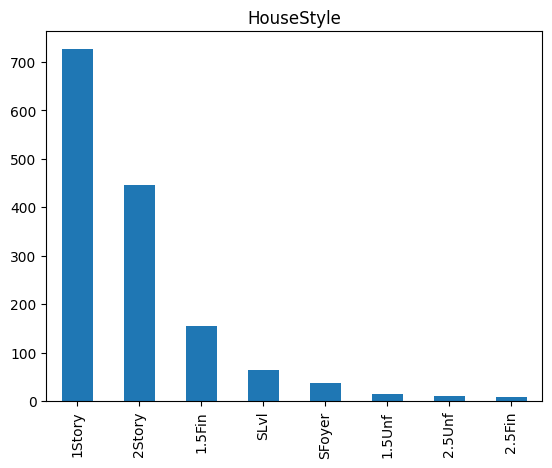

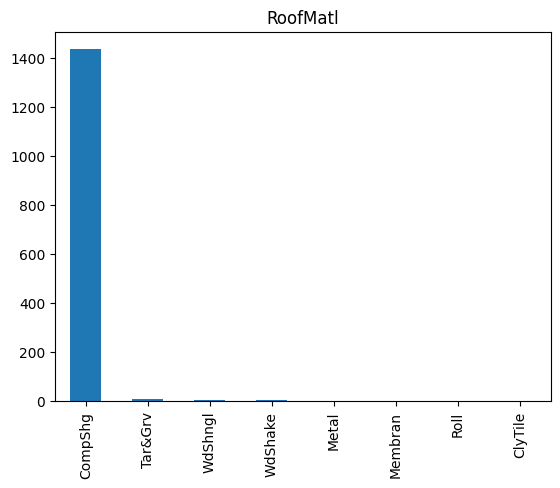

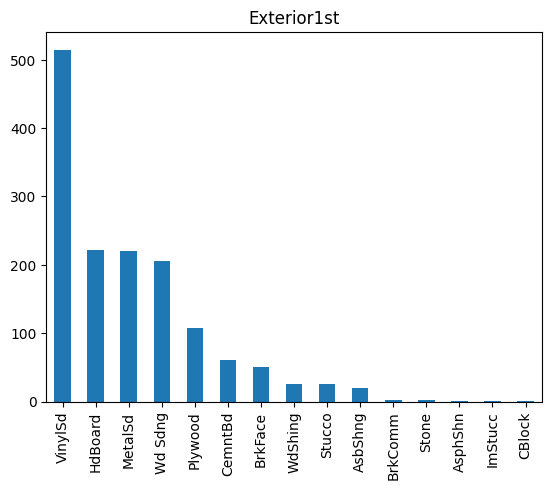

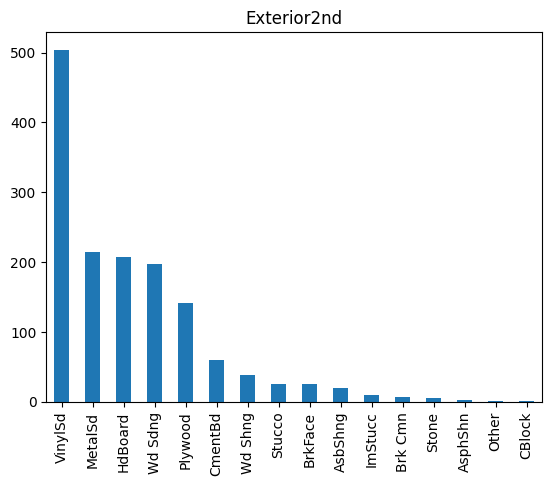

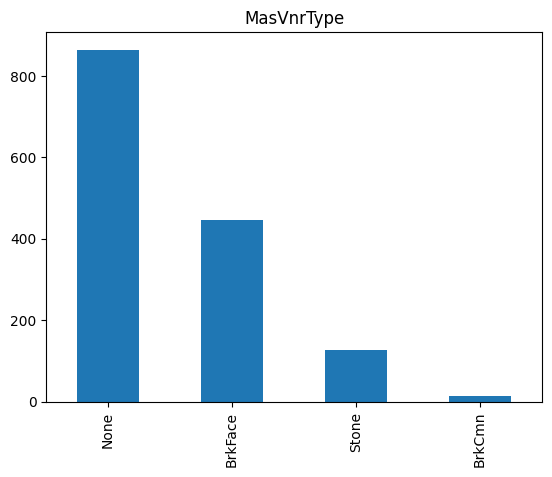

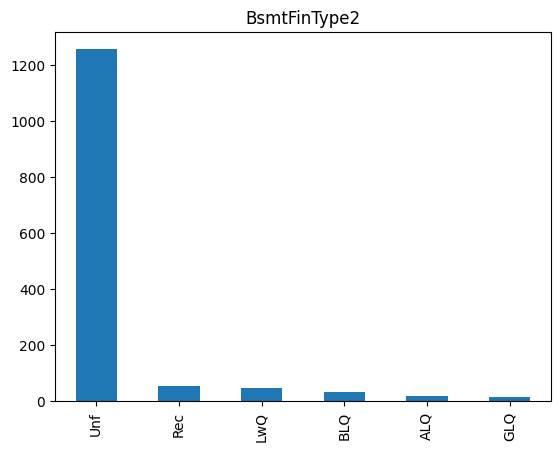

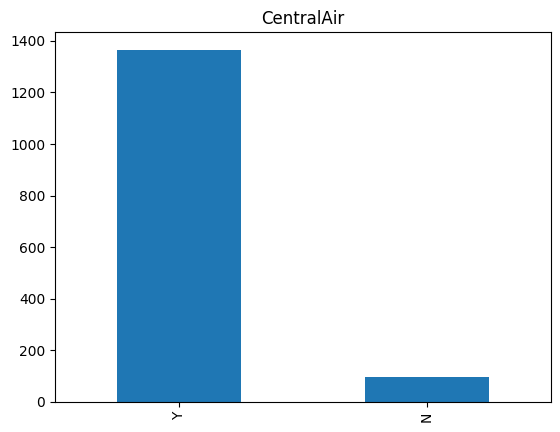

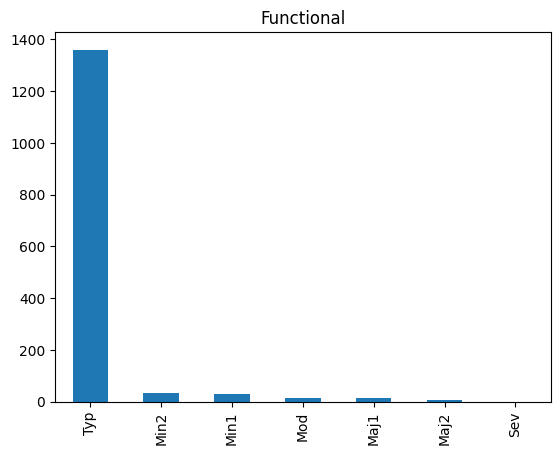

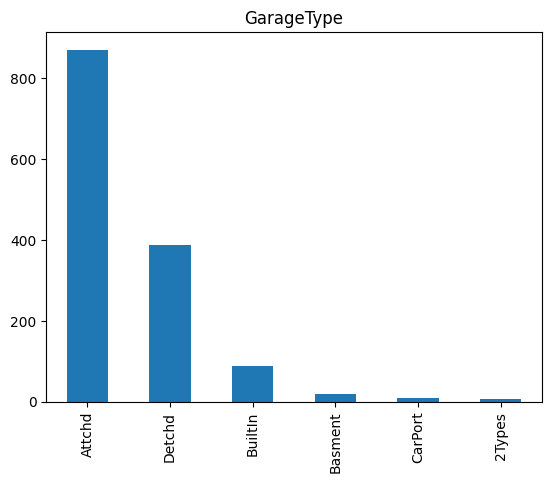

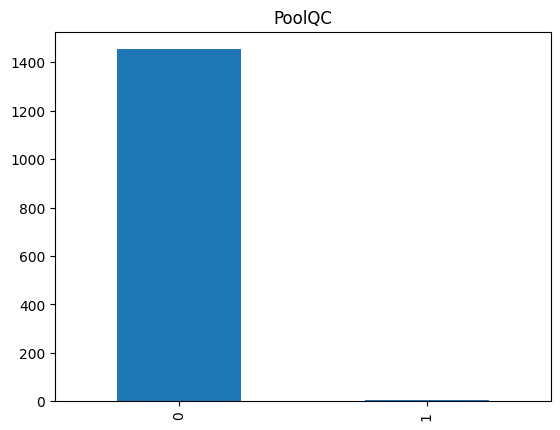

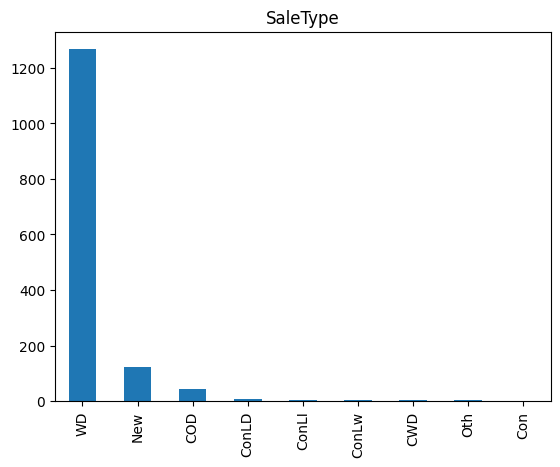

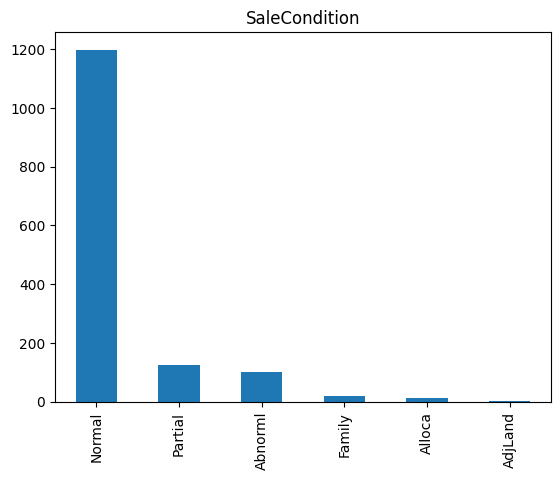

In [325]:
for var in unused_cat_cols:
    plt.title(var)
    train[var].value_counts().plot(kind = "bar")
    plt.show()

# Visualization

## Response behavior



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='SalePrice', ylabel='Density'>

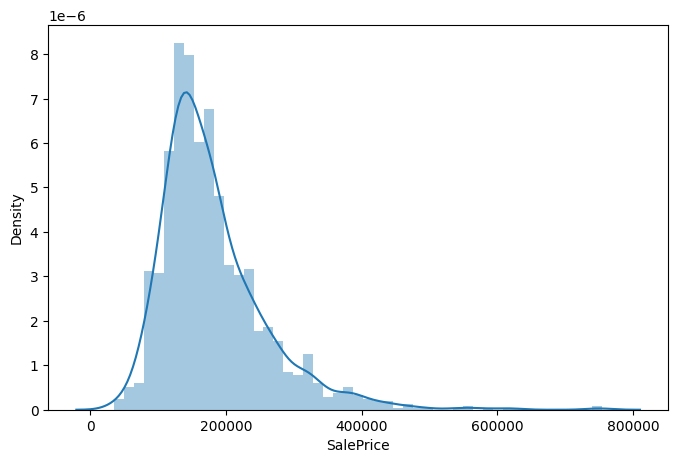

In [326]:
plt.figure(figsize=(8,5))
sns.distplot(train['SalePrice'])

Is quite right skewed, like a chi-square distribution. Might considder to make a log transform of SalePrice too make it closer to a normal distribution

## Correlation with response

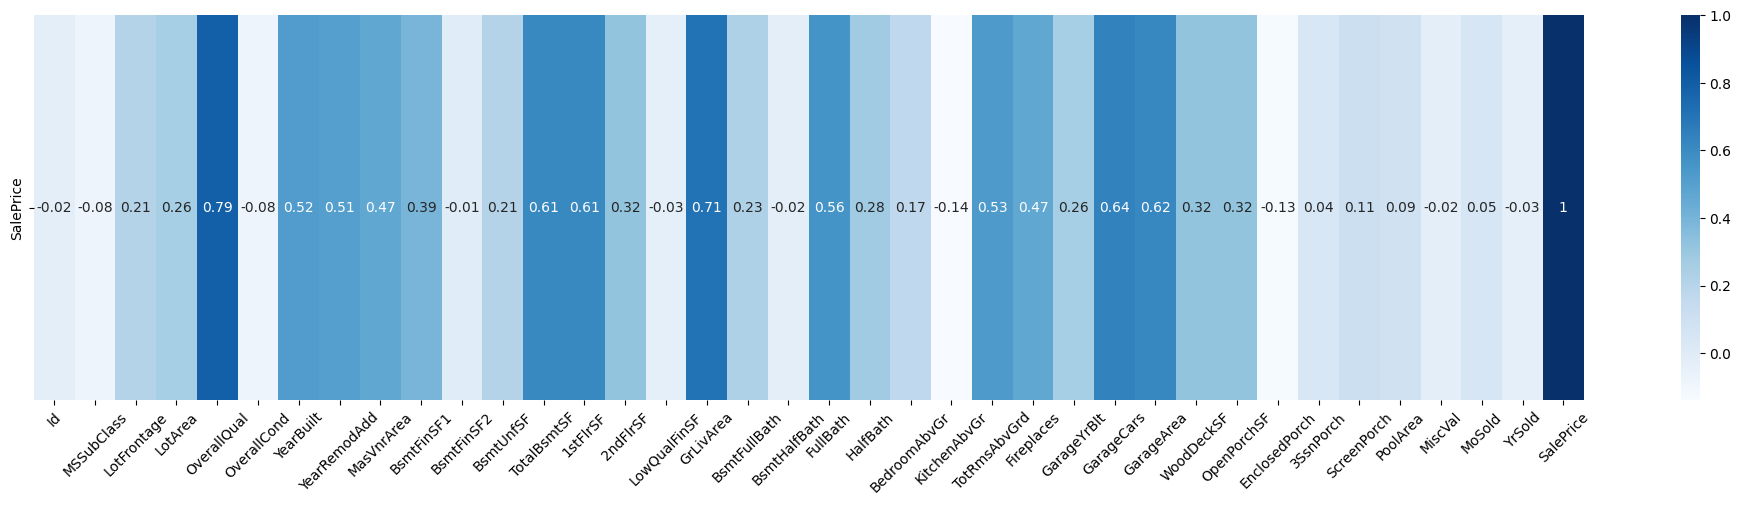

In [327]:
correlation = train[num_cols].corr().round(2)[-1:-2:-1]

# Plot
plt.figure(figsize=(25,5))
sns.heatmap(correlation, annot=True, cmap='Blues')
plt.xticks(rotation=45)
plt.show()

Ploting a pairplot of the variables that has the highest correlation with SalePrice

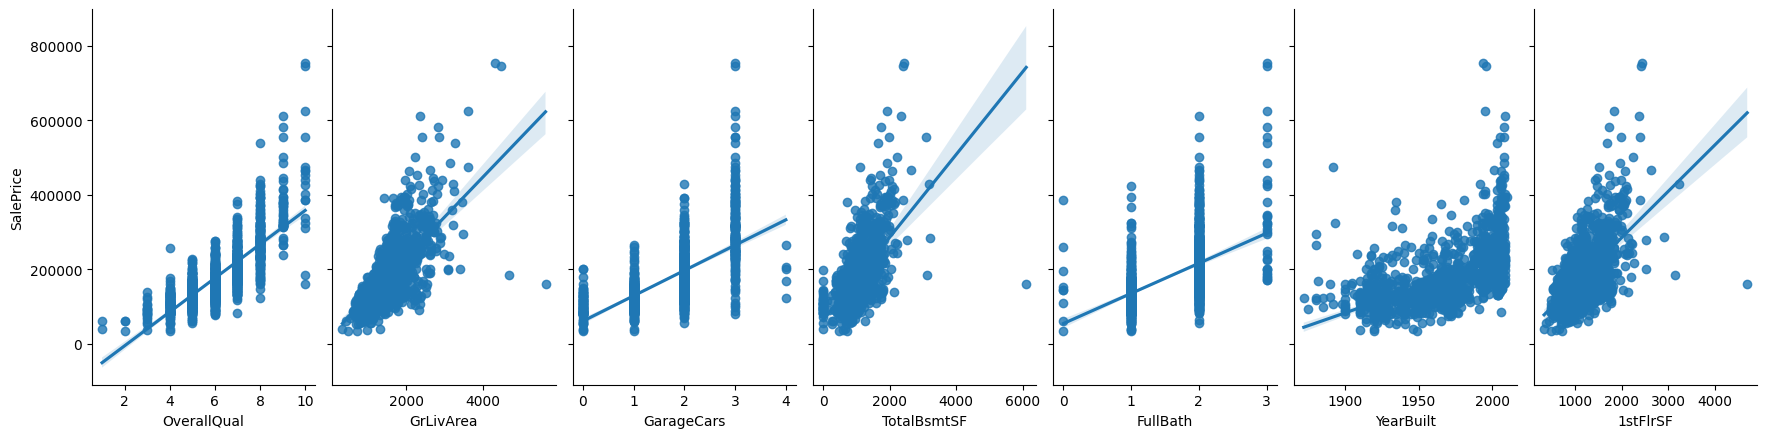

In [328]:
ax = sns.pairplot(train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF']], 
             y_vars=['SalePrice'],
             x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF'],
             height=2.5,
             kind='reg') # 'scatter'
ax.figure.set_size_inches(18, 5)

Taking a closer look at the most predictive variables

<Axes: xlabel='1stFlrSF', ylabel='Count'>

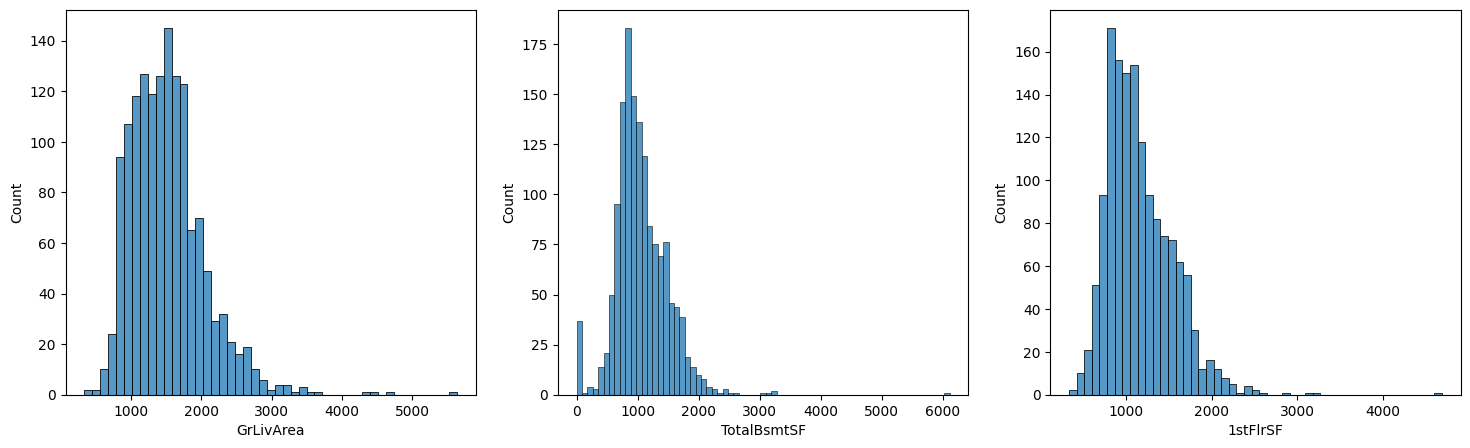

In [329]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=train['GrLivArea'], ax=ax[0])
sns.histplot(data=train['TotalBsmtSF'], ax=ax[1])
sns.histplot(data=train['1stFlrSF'], ax=ax[2])

See that all of them each have large outlier we want to remove.

In [330]:
train = train[train['GrLivArea']<4000]
train = train[train['TotalBsmtSF']<4000]
train = train[train['1stFlrSF']<4000]

Like we did with the response, we would like to log/squre root transform these varialbes to make them closer to normal distribution.

In [331]:
train['GrLivArea'] = np.log(train['GrLivArea'])
train['1stFlrSF'] = np.log(train['1stFlrSF'])

# TotalBsmtSF needs to be square root transformed since it has many zero values
train['TotalBsmtSF'] = np.sqrt(train['TotalBsmtSF'])

<Axes: xlabel='1stFlrSF', ylabel='Count'>

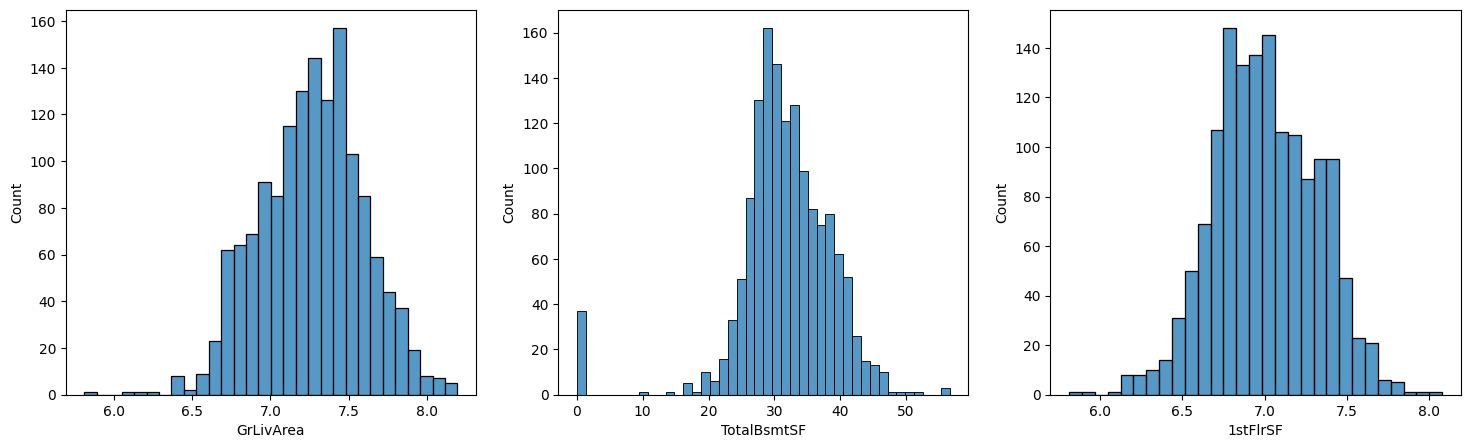

In [332]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=train['GrLivArea'], ax=ax[0])
sns.histplot(data=train['TotalBsmtSF'], ax=ax[1])
sns.histplot(data=train['1stFlrSF'], ax=ax[2])

### Heatmap

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


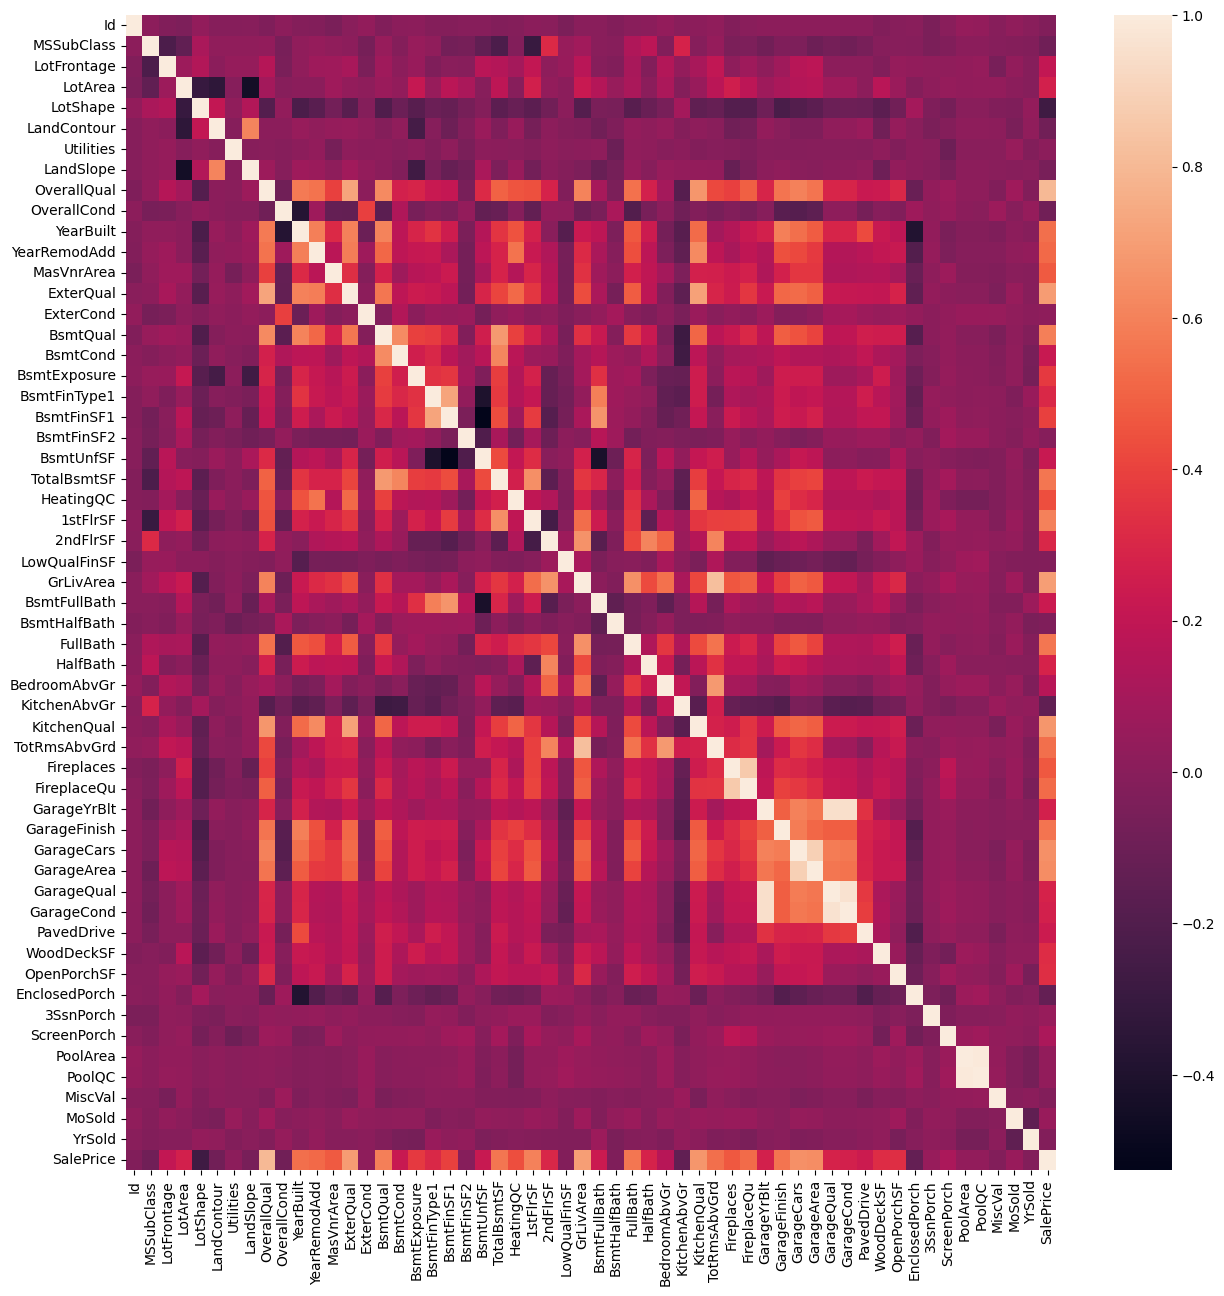

In [333]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr())
plt.show()

# Final Processing

In [334]:
predictors = ordinal_cols + num_cols
predictors.remove("Id")

In [335]:
X = train[predictors]
y = X.pop(response)

In [336]:
X_train , X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.2, random_state=42)

# Modeling

In [337]:
def score_dataset(X, y, model=xgb.XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

## XGBoost

In [340]:
xgb_model = xgb.XGBRegressor(
    n_estimators = 1000,
    learning_rate =  0.05,
    n_jobs = 4
    )

score_dataset(X, y, xgb_model)

0.1301335806777048

In [343]:
xgb_model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

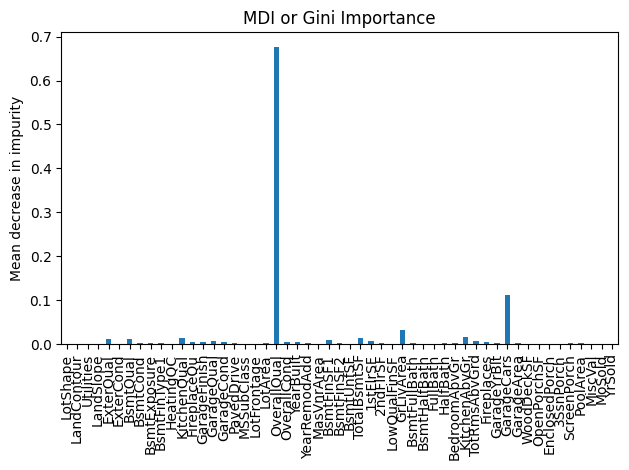

In [344]:
importances = xgb_model.feature_importances_
xgb_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [345]:
xgb_importances.sort_values(ascending=False)

OverallQual      0.675858
GarageCars       0.112341
GrLivArea        0.032062
KitchenAbvGr     0.016507
KitchenQual      0.014075
TotalBsmtSF      0.013554
BsmtQual         0.012598
ExterQual        0.010599
BsmtFinSF1       0.009740
TotRmsAbvGrd     0.008260
1stFlrSF         0.007608
GarageQual       0.007068
Fireplaces       0.005600
OverallCond      0.005281
GarageFinish     0.005060
FireplaceQu      0.004936
GarageCond       0.004557
YearBuilt        0.004092
YearRemodAdd     0.003726
BsmtCond         0.003630
BsmtFullBath     0.003288
LotArea          0.002782
GarageArea       0.002639
PavedDrive       0.002215
BsmtExposure     0.002206
HalfBath         0.002145
BedroomAbvGr     0.001988
2ndFlrSF         0.001846
BsmtFinType1     0.001829
PoolArea         0.001797
ScreenPorch      0.001750
BsmtFinSF2       0.001726
GarageYrBlt      0.001552
OpenPorchSF      0.001305
LandSlope        0.001280
LandContour      0.001109
EnclosedPorch    0.000998
FullBath         0.000956
MoSold      

In [346]:
best_vars = xgb_importances.sort_values(ascending=False).keys()[:10]

In [347]:
relavant_vars = xgb_importances.sort_values(ascending=False).keys()[:24]

### Tuning

### Random Search

In [355]:
params = {
 "learning_rate" : [0.001, 0.01, 0.05, 0.1],
 "max_depth" : [2, 3, 4, 5, 6, 8, 9, 10],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 ,0.6, 0.7 ]
}

In [356]:
xgb_opt_rand = RandomizedSearchCV(xgb.XGBRegressor(), params, n_jobs = -1)

xgb_opt_rand.fit(X, y)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 9, 10],
                                        'min_child_weight': [1, 3, 5, 7]})

In [358]:
xgb_parms =  xgb_opt_rand.best_params_
xgb_parms

{'min_child_weight': 7,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.6}

In [359]:
xgb_opt_model =  xgb.XGBRegressor(xgb_parms)


score_dataset(X, y, xgb_model)

Pass `objective` as keyword args.


0.1301335806777048

### Bayes Search

In [364]:
xgb_opt = BayesSearchCV(
    xgb.XGBRegressor(),
    {
        "learning_rate" : Real(1e-3, 0.1),
        "max_depth" : Integer(2, 10),
        "n_estimators" : Integer(1000, 8000),
        "min_child_weight" : Integer(1, 10),
        "colsample_bytree" : Real(0.2, 1.),
        "subsample" : Real(0.2, 1.),
        "reg_lambda" : Real(0., 10.),
        "reg_alpha" : Real(0., 10.)
    },
    n_iter= 50,
    random_state=42,
    verbose=1
)

xgb_opt.fit(X, y)

In [365]:
xgb_parms =  xgb_opt.best_params_
xgb_parms

## Random Forest

In [339]:
rf_model = RandomForestRegressor(n_estimators=300, n_jobs = 4)

score_dataset(X, y, rf_model)

0.13951699815494178

## KNN

In [368]:
knn_model = KNeighborsRegressor(n_neighbors=6, weights= "distance")

score_dataset(X, y, knn_model)

0.24029345821655448

In [366]:
knn_opt = BayesSearchCV(
    KNeighborsRegressor(weights= "distance"),
    {
        "n_neighbors" : Integer(1, 100)
    },
    n_iter= 50,
    random_state=42,
    verbose=1
)

knn_opt.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(estimator=KNeighborsRegressor(weights='distance'),
              random_state=42,
              search_spaces={'n_neighbors': Integer(low=1, high=100, prior='uniform', transform='normalize')},
              verbose=1)

In [367]:
knn_opt.best_params_

OrderedDict([('n_neighbors', 6)])